# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Francesco Pase"
student2 = "Murat  Topak"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [8]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import SGD, Adam

### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-directionù.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

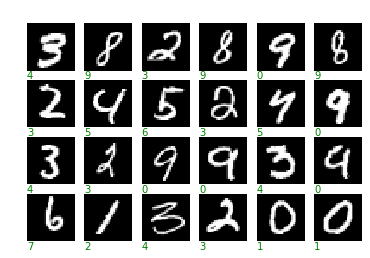

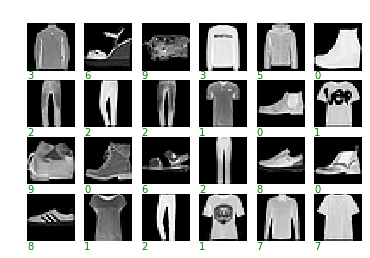

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) =  mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

plot_some_samples(x_train, y_train)
plot_some_samples(x_fashion_train, y_fashion_train);

Answer to question 2:

The green digits are the labels of the plotted input vectors.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [7]:
#MNIST

model = Sequential()
model.add(Dense(10, input_dim = 784, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=1)


pred = model.predict(x_test)
y_hat_test = np.argmax(pred, axis=1)
y_truth = np.argmax(y_test, axis=1)
err_indices = (y_hat_test != y_truth).nonzero()

plot_history(history, 'MNIST');
plot_some_samples(x_test, y_test, y_hat_test, err_indices[0]);



Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 1s 15us/step - loss: 1.4006 - acc: 0.6606 - val_loss: 0.8972 - val_acc: 0.8237
Epoch 2/50
48000/48000 [==============================] - 1s 14us/step - loss: 0.7955 - acc: 0.8279 - val_loss: 0.6571 - val_acc: 0.8588
Epoch 3/50
48000/48000 [==============================] - 1s 15us/step - loss: 0.6444 - acc: 0.8505 - val_loss: 0.5618 - val_acc: 0.8722
Epoch 4/50
13824/48000 [=======>......................] - ETA: 0s - loss: 0.5905 - acc: 0.8591

KeyboardInterrupt: 

In [ ]:
#MNIST FASHION
model = Sequential()
model.add(Dense(10, input_dim = 784, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=50, validation_split=0.2, verbose=1)


pred = model.predict(x_fashion_test)
y_hat_fashion_test = np.argmax(pred, axis=1)
y_fashion_truth = np.argmax(y_fashion_test, axis=1)
err_indices = (y_hat_fashion_test != y_fashion_truth).nonzero()

plot_history(history, 'Fashion-MNIST');
plot_some_samples(x_fashion_test, y_fashion_test, y_hat_fashion_test, err_indices[0]);

Answer to question 8:

They are both labels, the green being the true label, and the red being the predicted label. For example, in the MNIST dataset, we see a lot of 8,9,0 are misclassified. This makes sense since those 3 numbers highly resemble each other in terms of their shape and drawing. Of course, we can try to fine-tune the model or simply retrieve more data to reduce these mispredictions.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [10]:
from keras import optimizers


In [ ]:


model = Sequential()
model.add(Dense(128, input_dim = 784, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()


available_lr = [0.0001, 0.05, 0.9 ]
histories = []
for alr in available_lr:
    sgd = optimizers.SGD(lr = alr)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 50, validation_split = 0.2, verbose=1)
    histories.append(history)


In [12]:
def comparisonSGD_plot(histories, labels, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    linestyles = [':', '--', '-', ':']
    for (history,lbl, lstyle) in zip(histories, labels, linestyles):
        ax1.plot(history.history['loss'], label= str(lbl) + ' training', linestyle=lstyle)
        ax1.plot(history.history['val_loss'], label= str(lbl) + ' validation', linestyle=lstyle)
        ax2.plot(history.history['acc'], label= str(lbl) + ' training', linestyle=lstyle)
        ax2.plot(history.history['val_acc'], label= str(lbl) + ' validation', linestyle=lstyle)

    fig.suptitle(title, x=0.8)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels, loc='upper right', bbox_to_anchor=(0.5, -0.2), ncol=3)
    plt.subplots_adjust(right=1.5)
    #fig.tight_layout()
    return fig


In [ ]:
comparisonSGD_plot(histories, available_lr, 'VARIOUS LRs');

In [13]:
# This plotting routine might help you ...

def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig




In [ ]:
model = Sequential()
model.add(Dense(128, input_dim = 784, activation='relu'))
model.add(Dense(10, activation='softmax'))

#model.summary()

sgd = optimizers.SGD(lr = 0.01)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
historySGD = model.fit(x_train, y_train, batch_size = 128, epochs = 50, validation_split = 0.2, verbose=1)

adam = optimizers.Adam(lr = 0.01)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
historyAdam = model.fit(x_train, y_train, batch_size = 128, epochs = 50, validation_split = 0.2, verbose=1)


_ = comparison_plot(historySGD, historyAdam, 'SGD', 'Adam', 'SGD vs Adam with lr=0.01');

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim = 784, activation='relu'))
model.add(Dense(10, activation='softmax'))


adam = optimizers.Adam(lr = 0.01)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
historyAdam = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 50, validation_split = 0.2, verbose=1)
plot_history(historyAdam, 'Adam on Fashion-MNIST');

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) In the first figure, we see that the model follows a fluctuated learning curve as opposed to the optimal learning rate as at each step it is likely to end up missing the local optimum due to high learning rate.

B) Again from the first figure we conclude that the model tends to underperform, meaning that it does not achieve the best it can due to low learning rate as at each step the weights tend to stay the same because of the low learning rate

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: From the red curve in the last figure, we see the loss on validation set starts to increase at around epoch 5-10, indicating a possible overfit.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

TOOOOOOOOOOOOOOOOOOOOOOOOOOOO DOOOOOOOOOOOOOOOOOOO

**Answer**: We decided to analyze Adam experiment. The first difference is that validation Loss and Accuracy curves present different behaviours , so while the Loss one goes up above the training Loss, the Accuracy curve doesn't change much over time. This is most likely the case because while overfitting, the errors in the misclassified validation samples icrease but the prectentage of right and wrong predictions remained the same.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [ ]:

def comparison_layer(histories,num_units, title):
    fig, ax1, ax2 = prepare_standardplot(title, "# of units")
    best_val_losses = [min(history.history['val_loss']) for history in histories]
    best_val_accs = [max(history.history['val_acc']) for history in histories]

    ax1.plot(num_units, best_val_losses, marker='o', linestyle='--')

    ax2.plot(num_units, best_val_accs, marker='o', linestyle='--')

    finalize_standardplot(fig, ax1, ax2)
    ax2.set_ylim([0.9,1])
    ax1.set_ylim([0.1,0.3])
    return fig


In [ ]:




num_units = [10, 20, 40, 80, 160, 320, 640, 1000]
histories = []
for u in num_units:
    model = Sequential()
    model.add(Dense(u, input_dim = 784, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    adam = optimizers.Adam(lr = 0.01)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(x_train, y_train, batch_size = 128, epochs = 10, validation_split = 0.2, verbose=1)
    histories.append(history)




In [ ]:
comparison_layer(histories, num_units, 'Loss and Accuracy vs. # of Units');


Answer to question 2:

Indeed, the figures are in accordance with the general approximation theorem although through the end we see an upward trend in the loss plot. This is also expected since the data is 784-d but we even tried 1000 units, so it is most likely we overfitted in that area.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [10]:
#Standard Model - No Tricks
histories = dict()
model = Sequential()
model.add(Dense(50, input_dim = 784, activation='relu'))

model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 100, validation_split = 0.2, verbose=1)
histories["NoTrick"] = history


Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 28us/step - loss: 0.6531 - acc: 0.7750 - val_loss: 0.4823 - val_acc: 0.8343
Epoch 2/100
48000/48000 [==============================] - 1s 28us/step - loss: 0.4489 - acc: 0.8439 - val_loss: 0.4272 - val_acc: 0.8517
Epoch 3/100
48000/48000 [==============================] - 1s 28us/step - loss: 0.4082 - acc: 0.8573 - val_loss: 0.4069 - val_acc: 0.8571
Epoch 4/100
48000/48000 [==============================] - 1s 31us/step - loss: 0.3797 - acc: 0.8671 - val_loss: 0.4052 - val_acc: 0.8563
Epoch 5/100
48000/48000 [==============================] - 2s 32us/step - loss: 0.3641 - acc: 0.8719 - val_loss: 0.3953 - val_acc: 0.8622
Epoch 6/100
48000/48000 [==============================] - 2s 33us/step - loss: 0.3497 - acc: 0.8751 - val_loss: 0.3698 - val_acc: 0.8695
Epoch 7/100
48000/48000 [==============================] - 1s 30us/step - loss: 0.3339 - acc: 0.8809 - val_loss: 0.3614 - 

48000/48000 [==============================] - 1s 20us/step - loss: 0.1606 - acc: 0.9419 - val_loss: 0.3661 - val_acc: 0.8859
Epoch 60/100
48000/48000 [==============================] - 1s 21us/step - loss: 0.1569 - acc: 0.9444 - val_loss: 0.3657 - val_acc: 0.8862
Epoch 61/100
48000/48000 [==============================] - 1s 20us/step - loss: 0.1581 - acc: 0.9432 - val_loss: 0.3741 - val_acc: 0.8852
Epoch 62/100
48000/48000 [==============================] - 1s 19us/step - loss: 0.1555 - acc: 0.9446 - val_loss: 0.3732 - val_acc: 0.8846
Epoch 63/100
48000/48000 [==============================] - 1s 19us/step - loss: 0.1573 - acc: 0.9436 - val_loss: 0.3874 - val_acc: 0.8842
Epoch 64/100
48000/48000 [==============================] - 1s 20us/step - loss: 0.1537 - acc: 0.9446 - val_loss: 0.3722 - val_acc: 0.8872
Epoch 65/100
48000/48000 [==============================] - 1s 19us/step - loss: 0.1528 - acc: 0.9450 - val_loss: 0.3854 - val_acc: 0.8813
Epoch 66/100
48000/48000 [==============

In [11]:
#Batch Normalization, Speed convergence, overfitting amplified

model = Sequential()
model.add(Dense(50, input_dim = 784, activation='linear'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.00001))
model.add(Activation('relu'))

model.add(Dense(10, activation='linear'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.00001))
model.add(Activation('softmax'))
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 100, validation_split = 0.2, verbose=1)
histories["BatchNorm"] = history




Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 37us/step - loss: 0.7591 - acc: 0.8041 - val_loss: 0.6190 - val_acc: 0.8233
Epoch 2/100
48000/48000 [==============================] - 1s 25us/step - loss: 0.5176 - acc: 0.8564 - val_loss: 0.4864 - val_acc: 0.8511
Epoch 3/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.4364 - acc: 0.8711 - val_loss: 0.4323 - val_acc: 0.8616
Epoch 4/100
48000/48000 [==============================] - 1s 25us/step - loss: 0.3915 - acc: 0.8800 - val_loss: 0.4291 - val_acc: 0.8618
Epoch 5/100
48000/48000 [==============================] - 1s 26us/step - loss: 0.3615 - acc: 0.8854 - val_loss: 0.3964 - val_acc: 0.8723
Epoch 6/100
48000/48000 [==============================] - 2s 36us/step - loss: 0.3367 - acc: 0.8911 - val_loss: 0.3729 - val_acc: 0.8770
Epoch 7/100
48000/48000 [==============================] - 1s 31us/step - loss: 0.3213 - acc: 0.8942 - val_loss: 0.3777 - 

48000/48000 [==============================] - 1s 25us/step - loss: 0.1138 - acc: 0.9613 - val_loss: 0.4835 - val_acc: 0.8681
Epoch 60/100
48000/48000 [==============================] - 1s 25us/step - loss: 0.1106 - acc: 0.9621 - val_loss: 0.5087 - val_acc: 0.8623
Epoch 61/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.1116 - acc: 0.9607 - val_loss: 0.5076 - val_acc: 0.8648
Epoch 62/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.1102 - acc: 0.9608 - val_loss: 0.5410 - val_acc: 0.8511
Epoch 63/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.1110 - acc: 0.9621 - val_loss: 0.4617 - val_acc: 0.8678
Epoch 64/100
48000/48000 [==============================] - 1s 25us/step - loss: 0.1083 - acc: 0.9625 - val_loss: 0.4864 - val_acc: 0.8671
Epoch 65/100
48000/48000 [==============================] - 1s 24us/step - loss: 0.1086 - acc: 0.9636 - val_loss: 0.4729 - val_acc: 0.8758
Epoch 66/100
48000/48000 [==============

In [40]:
#Dropout + Batch Normalization, Best model found, Best Loss

model = Sequential()
model.add(Dense(50, input_dim = 784, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.45))



model.add(Dense(10, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('softmax'))
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 100, validation_split = 0.2, verbose=1)



histories["Dropout"] = history




Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 64us/step - loss: 0.9884 - acc: 0.7433 - val_loss: 0.6499 - val_acc: 0.8311
Epoch 2/100
48000/48000 [==============================] - 2s 35us/step - loss: 0.7290 - acc: 0.8055 - val_loss: 0.5612 - val_acc: 0.8445
Epoch 3/100
48000/48000 [==============================] - 2s 36us/step - loss: 0.6399 - acc: 0.8179 - val_loss: 0.5007 - val_acc: 0.8520
Epoch 4/100
48000/48000 [==============================] - 2s 40us/step - loss: 0.5918 - acc: 0.8269 - val_loss: 0.4647 - val_acc: 0.8550
Epoch 5/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.5564 - acc: 0.8322 - val_loss: 0.4636 - val_acc: 0.8580
Epoch 6/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.5357 - acc: 0.8352 - val_loss: 0.4312 - val_acc: 0.8572
Epoch 7/100
48000/48000 [==============================] - 2s 44us/step - loss: 0.5173 - acc: 0.8378 - val_loss: 0.4156 - 

48000/48000 [==============================] - 2s 38us/step - loss: 0.3578 - acc: 0.8696 - val_loss: 0.3540 - val_acc: 0.8720
Epoch 60/100
48000/48000 [==============================] - 2s 41us/step - loss: 0.3565 - acc: 0.8706 - val_loss: 0.3419 - val_acc: 0.8788
Epoch 61/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.3609 - acc: 0.8689 - val_loss: 0.3479 - val_acc: 0.8753
Epoch 62/100
48000/48000 [==============================] - 2s 38us/step - loss: 0.3569 - acc: 0.8704 - val_loss: 0.3492 - val_acc: 0.8755
Epoch 63/100
48000/48000 [==============================] - 2s 38us/step - loss: 0.3539 - acc: 0.8715 - val_loss: 0.3516 - val_acc: 0.8761
Epoch 64/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.3556 - acc: 0.8710 - val_loss: 0.3544 - val_acc: 0.8736
Epoch 65/100
48000/48000 [==============================] - 2s 40us/step - loss: 0.3513 - acc: 0.8736 - val_loss: 0.3558 - val_acc: 0.8765
Epoch 66/100
48000/48000 [==============

In [33]:
#L1 Normalization, less overfitting but not best Accuracy
model = Sequential()

model.add(Dense(50, input_dim = 784, activation='relu', kernel_regularizer= regularizers.l1(0.0009), bias_regularizer = regularizers.l1(0.0009)))
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 100, validation_split = 0.2, verbose=1)
histories["L1-Norm"] = history




Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 59us/step - loss: 1.3818 - acc: 0.7661 - val_loss: 0.9414 - val_acc: 0.8152
Epoch 2/100
48000/48000 [==============================] - 2s 35us/step - loss: 0.8522 - acc: 0.8158 - val_loss: 0.8008 - val_acc: 0.8172
Epoch 3/100
48000/48000 [==============================] - 2s 33us/step - loss: 0.7691 - acc: 0.8174 - val_loss: 0.7470 - val_acc: 0.8231
Epoch 4/100
48000/48000 [==============================] - 1s 30us/step - loss: 0.7258 - acc: 0.8218 - val_loss: 0.7073 - val_acc: 0.8243
Epoch 5/100
48000/48000 [==============================] - 2s 31us/step - loss: 0.6992 - acc: 0.8267 - val_loss: 0.6912 - val_acc: 0.8249
Epoch 6/100
48000/48000 [==============================] - 1s 28us/step - loss: 0.6868 - acc: 0.8277 - val_loss: 0.6782 - val_acc: 0.8305
Epoch 7/100
48000/48000 [==============================] - 1s 28us/step - loss: 0.6713 - acc: 0.8294 - val_loss: 0.6749 - 

48000/48000 [==============================] - 2s 38us/step - loss: 0.5217 - acc: 0.8615 - val_loss: 0.5361 - val_acc: 0.8558
Epoch 60/100
48000/48000 [==============================] - 1s 25us/step - loss: 0.5209 - acc: 0.8591 - val_loss: 0.5468 - val_acc: 0.8505
Epoch 61/100
48000/48000 [==============================] - 1s 29us/step - loss: 0.5224 - acc: 0.8597 - val_loss: 0.5473 - val_acc: 0.8471
Epoch 62/100
48000/48000 [==============================] - 1s 26us/step - loss: 0.5190 - acc: 0.8608 - val_loss: 0.5401 - val_acc: 0.8537
Epoch 63/100
48000/48000 [==============================] - 2s 31us/step - loss: 0.5136 - acc: 0.8625 - val_loss: 0.5426 - val_acc: 0.8503
Epoch 64/100
48000/48000 [==============================] - 1s 31us/step - loss: 0.5178 - acc: 0.8605 - val_loss: 0.5266 - val_acc: 0.8568
Epoch 65/100
48000/48000 [==============================] - 2s 34us/step - loss: 0.5130 - acc: 0.8619 - val_loss: 0.5439 - val_acc: 0.8524
Epoch 66/100
48000/48000 [==============

In [35]:
#L2 Normalization, better than L1, but not best

model = Sequential()

model.add(Dense(50, input_dim = 784, activation='relu', kernel_regularizer= regularizers.l2(0.005), bias_regularizer = regularizers.l2(0.005)))

model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_fashion_train, y_fashion_train, batch_size = 128, epochs = 100, validation_split = 0.2, verbose=1)
histories["L2-Norm"] = history




Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 50us/step - loss: 0.9243 - acc: 0.7819 - val_loss: 0.6816 - val_acc: 0.8257
Epoch 2/100
48000/48000 [==============================] - 1s 30us/step - loss: 0.6316 - acc: 0.8325 - val_loss: 0.5865 - val_acc: 0.8410
Epoch 3/100
48000/48000 [==============================] - 2s 34us/step - loss: 0.5766 - acc: 0.8394 - val_loss: 0.5676 - val_acc: 0.8373
Epoch 4/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.5528 - acc: 0.8428 - val_loss: 0.5554 - val_acc: 0.8377
Epoch 5/100
48000/48000 [==============================] - 1s 29us/step - loss: 0.5353 - acc: 0.8459 - val_loss: 0.5277 - val_acc: 0.8481
Epoch 6/100
48000/48000 [==============================] - 1s 30us/step - loss: 0.5184 - acc: 0.8511 - val_loss: 0.5155 - val_acc: 0.8497
Epoch 7/100
48000/48000 [==============================] - 2s 33us/step - loss: 0.5130 - acc: 0.8508 - val_loss: 0.5219 - 

48000/48000 [==============================] - 1s 28us/step - loss: 0.4067 - acc: 0.8768 - val_loss: 0.4597 - val_acc: 0.8634
Epoch 60/100
48000/48000 [==============================] - 1s 26us/step - loss: 0.4084 - acc: 0.8781 - val_loss: 0.4406 - val_acc: 0.8691
Epoch 61/100
48000/48000 [==============================] - 2s 31us/step - loss: 0.4110 - acc: 0.8743 - val_loss: 0.4428 - val_acc: 0.8630
Epoch 62/100
48000/48000 [==============================] - 1s 30us/step - loss: 0.3985 - acc: 0.8800 - val_loss: 0.4564 - val_acc: 0.8593
Epoch 63/100
48000/48000 [==============================] - 1s 29us/step - loss: 0.4118 - acc: 0.8742 - val_loss: 0.4261 - val_acc: 0.8737
Epoch 64/100
48000/48000 [==============================] - 1s 29us/step - loss: 0.4034 - acc: 0.8789 - val_loss: 0.4323 - val_acc: 0.8678
Epoch 65/100
48000/48000 [==============================] - 1s 31us/step - loss: 0.4025 - acc: 0.8798 - val_loss: 0.4302 - val_acc: 0.8702
Epoch 66/100
48000/48000 [==============

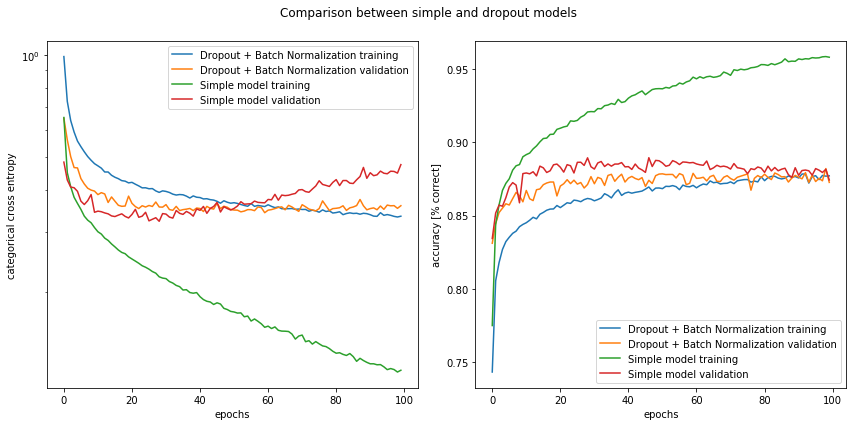

In [42]:
#Comparison with Best Model : Dropout + Batch Normalization

comparison_plot(histories["Dropout"], histories["NoTrick"], 'Dropout + Batch Normalization', 'Simple model', 'Comparison between simple and dropout models');

Answer to question 2 (comments):

We chose the Droput model with batch normalization layers that presents, after 100 epochs, a stable behaviour in terms of validation loss and accuracy being less prone to overfitting and obtaining the best scores obtained by the simple model within the 100 epochs. Other tricks like batch normalization could help improving the model, especially in the convergence speed of the training phase. 

In [44]:
#Best Model applied to MNIST
#Dropout + Batch Normalization

model = Sequential()
model.add(Dense(50, input_dim = 784, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.45))



model.add(Dense(10, activation='linear'))
model.add(BatchNormalization())
model.add(Activation('softmax'))
adam = optimizers.Adam(lr = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, batch_size = 128, epochs = 100, validation_split = 0.2, verbose=1)



histories["DropoutMNIST"] = history




Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 75us/step - loss: 0.9631 - acc: 0.7853 - val_loss: 0.4848 - val_acc: 0.9271
Epoch 2/100
48000/48000 [==============================] - 2s 36us/step - loss: 0.6144 - acc: 0.8742 - val_loss: 0.3678 - val_acc: 0.9398
Epoch 3/100
48000/48000 [==============================] - 2s 36us/step - loss: 0.5097 - acc: 0.8866 - val_loss: 0.2845 - val_acc: 0.9478
Epoch 4/100
48000/48000 [==============================] - 2s 38us/step - loss: 0.4528 - acc: 0.8947 - val_loss: 0.2390 - val_acc: 0.9502
Epoch 5/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.4143 - acc: 0.8987 - val_loss: 0.2189 - val_acc: 0.9521
Epoch 6/100
48000/48000 [==============================] - 2s 39us/step - loss: 0.3817 - acc: 0.9030 - val_loss: 0.2119 - val_acc: 0.9530
Epoch 7/100
48000/48000 [==============================] - 2s 40us/step - loss: 0.3567 - acc: 0.9084 - val_loss: 0.1840 - 

48000/48000 [==============================] - 2s 51us/step - loss: 0.1976 - acc: 0.9380 - val_loss: 0.1201 - val_acc: 0.9662
Epoch 60/100
48000/48000 [==============================] - 3s 65us/step - loss: 0.1967 - acc: 0.9383 - val_loss: 0.1200 - val_acc: 0.9660
Epoch 61/100
48000/48000 [==============================] - 2s 52us/step - loss: 0.1964 - acc: 0.9380 - val_loss: 0.1153 - val_acc: 0.9682
Epoch 62/100
48000/48000 [==============================] - 2s 31us/step - loss: 0.1948 - acc: 0.9400 - val_loss: 0.1176 - val_acc: 0.9666
Epoch 63/100
48000/48000 [==============================] - 2s 32us/step - loss: 0.1913 - acc: 0.9395 - val_loss: 0.1185 - val_acc: 0.9662
Epoch 64/100
48000/48000 [==============================] - 1s 30us/step - loss: 0.1914 - acc: 0.9392 - val_loss: 0.1183 - val_acc: 0.9657
Epoch 65/100
48000/48000 [==============================] - 2s 41us/step - loss: 0.1935 - acc: 0.9386 - val_loss: 0.1193 - val_acc: 0.9663
Epoch 66/100
48000/48000 [==============

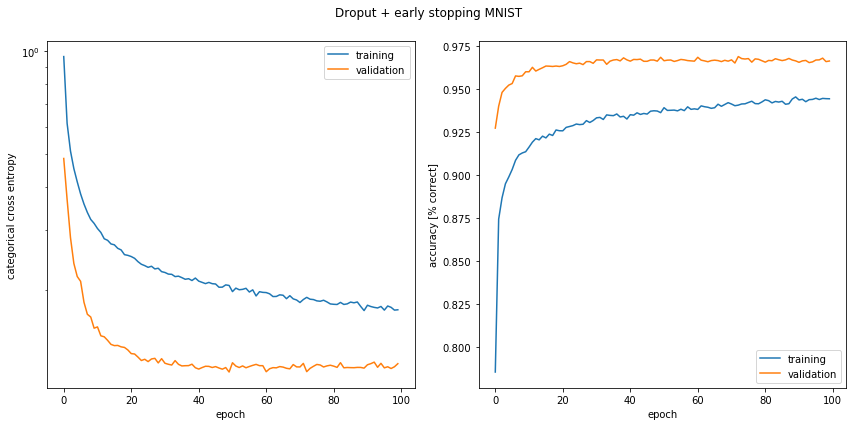

In [45]:
plot_history(histories["DropoutMNIST"], "Droput + early stopping MNIST");
#plot_history(history, "Droput + early stopping MNIST");

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [15]:
CNN_x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
CNN_x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

CNN_x_train_fashion = x_fashion_train.reshape(x_fashion_train.shape[0], 28, 28, 1)
CNN_x_test_fashion = x_fashion_test.reshape(x_fashion_test.shape[0], 28, 28, 1)


In [52]:
#MNIST

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

hist = model.fit(CNN_x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split = 0.2)
    
#plot_history(hist, 'CNN History');

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 94s 2ms/step - loss: 0.3304 - acc: 0.8977 - val_loss: 0.0790 - val_acc: 0.9779
Epoch 2/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.1103 - acc: 0.9666 - val_loss: 0.0546 - val_acc: 0.9838
Epoch 3/10
48000/48000 [==============================] - 99s 2ms/step - loss: 0.0837 - acc: 0.9742 - val_loss: 0.0471 - val_acc: 0.9857
Epoch 4/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0693 - acc: 0.9791 - val_loss: 0.0454 - val_acc: 0.9866
Epoch 5/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0635 - acc: 0.9810 - val_loss: 0.0416 - val_acc: 0.9882
Epoch 6/10
48000/48000 [==============================] - 99s 2ms/step - loss: 0.0584 - acc: 0.9824 - val_loss: 0.0398 - val_acc: 0.9886
Epoch 7/10
48000/48000 [==============================] - 99s 2ms/step - loss: 0.0517 - acc: 0.9844 - val_loss: 0.0406 - val_acc

In [65]:
#MNIST Fashion

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

hist_fashion = model.fit(CNN_x_train_fashion, y_fashion_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split = 0.2)
    
#plot_history(hist, 'CNN History');

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 96s 2ms/step - loss: 0.6227 - acc: 0.7767 - val_loss: 0.3759 - val_acc: 0.8632
Epoch 2/10
48000/48000 [==============================] - 100s 2ms/step - loss: 0.3967 - acc: 0.8580 - val_loss: 0.3090 - val_acc: 0.8851
Epoch 3/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.3461 - acc: 0.8756 - val_loss: 0.2797 - val_acc: 0.8972
Epoch 4/10
48000/48000 [==============================] - 101s 2ms/step - loss: 0.3175 - acc: 0.8866 - val_loss: 0.2629 - val_acc: 0.9045
Epoch 5/10
48000/48000 [==============================] - 106s 2ms/step - loss: 0.2944 - acc: 0.8947 - val_loss: 0.2544 - val_acc: 0.9042
Epoch 6/10
48000/48000 [==============================] - 99s 2ms/step - loss: 0.2779 - acc: 0.9009 - val_loss: 0.2391 - val_acc: 0.9119
Epoch 7/10
48000/48000 [==============================] - 97s 2ms/step - loss: 0.2633 - acc: 0.9050 - val_loss: 0.2326 - val_

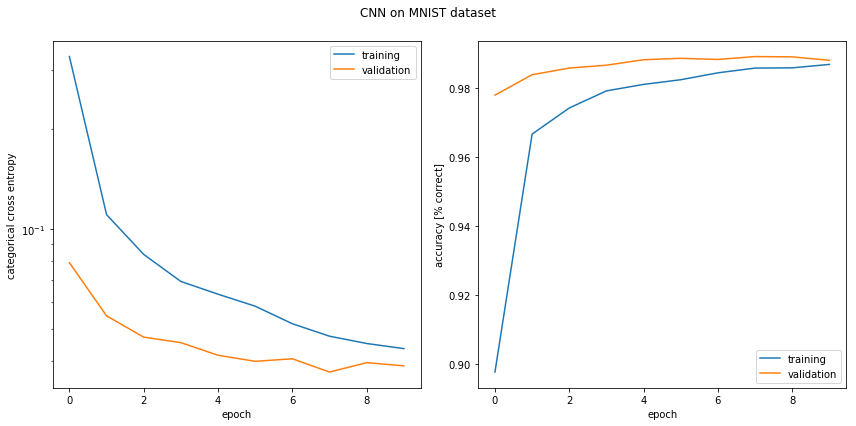

In [66]:
plot_history(hist, 'CNN on MNIST dataset');

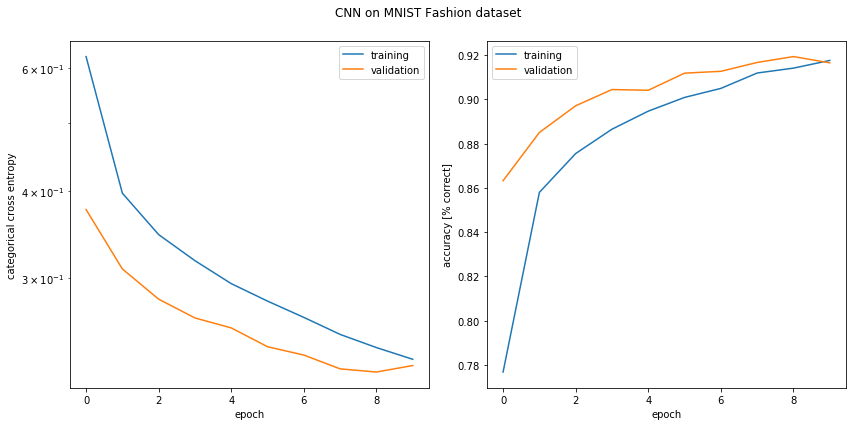

In [67]:
plot_history(hist_fashion, 'CNN on MNIST Fashion dataset');

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

hist_model = model.fit(CNN_x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split = 0.2)

#Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
    


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 99s 2ms/step - loss: 2.3203 - acc: 0.1104 - val_loss: 2.3023 - val_acc: 0.1060
Epoch 2/10
48000/48000 [==============================] - 95s 2ms/step - loss: 2.3015 - acc: 0.1141 - val_loss: 2.3019 - val_acc: 0.1060
Epoch 3/10
48000/48000 [==============================] - 93s 2ms/step - loss: 2.3012 - acc: 0.1140 - val_loss: 2.3018 - val_acc: 0.1060
Epoch 4/10
48000/48000 [==============================] - 93s 2ms/step - loss: 2.3011 - acc: 0.1139 - val_loss: 2.3011 - val_acc: 0.1060
Epoch 5/10
48000/48000 [==============================] - 92s 2ms/step - loss: 1.3118 - acc: 0.5291 - val_loss: 0.3111 - val_acc: 0.9097
Epoch 6/10
48000/48000 [==============================] - 91s 2ms/step - loss: 0.3948 - acc: 0.8829 - val_loss: 0.2407 - val_acc: 0.9277
Epoch 7/10
48000/48000 [==============================] - 91s 2ms/step - loss: 0.3189 - acc: 0.9050 - val_loss: 0.1888 - val_acc

Answer to question 1:

We observe that for the network is much more difficult to learn the right parameters as the sigmoid outputs tend to saturate and the gradient vanishes for those neurons, making the convergence very slow.

In [18]:
cnn_batch = Sequential()
cnn_batch.add(Conv2D(32, kernel_size=(3, 3),
                 activation='linear',
                 input_shape=(28,28,1)))
cnn_batch.add(BatchNormalization())
cnn_batch.add(Activation('sigmoid'))
cnn_batch.add(Conv2D(64, (3, 3), activation='linear'))
cnn_batch.add(BatchNormalization())
cnn_batch.add(Activation('sigmoid'))
cnn_batch.add(MaxPooling2D(pool_size=(2, 2)))
cnn_batch.add(Dropout(0.5))
cnn_batch.add(Flatten())
cnn_batch.add(Dense(128, activation='linear'))
cnn_batch.add(BatchNormalization())
cnn_batch.add(Activation('sigmoid'))
cnn_batch.add(Dropout(0.5))
cnn_batch.add(Dense(10, activation='linear'))
cnn_batch.add(BatchNormalization())
cnn_batch.add(Activation('softmax'))

cnn_batch.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

hist_cnn_batch = cnn_batch.fit(CNN_x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_split = 0.2)

#Serialize model to JSON
model_json = cnn_batch.to_json()
with open("model_batch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_batch.save_weights("model_batch.h5")
print("Saved model to disk")
 
    


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 228s 5ms/step - loss: 0.9465 - acc: 0.7740 - val_loss: 1.2653 - val_acc: 0.6220
Epoch 2/10
48000/48000 [==============================] - 227s 5ms/step - loss: 0.4659 - acc: 0.9129 - val_loss: 0.4893 - val_acc: 0.8630
Epoch 3/10
48000/48000 [==============================] - 219s 5ms/step - loss: 0.3082 - acc: 0.9395 - val_loss: 0.2456 - val_acc: 0.9461
Epoch 4/10
48000/48000 [==============================] - 219s 5ms/step - loss: 0.2327 - acc: 0.9515 - val_loss: 0.1189 - val_acc: 0.9772
Epoch 5/10
48000/48000 [==============================] - 217s 5ms/step - loss: 0.1871 - acc: 0.9579 - val_loss: 0.1342 - val_acc: 0.9667
Epoch 6/10
48000/48000 [==============================] - 218s 5ms/step - loss: 0.1611 - acc: 0.9624 - val_loss: 0.1014 - val_acc: 0.9752
Epoch 7/10
48000/48000 [==============================] - 224s 5ms/step - loss: 0.1402 - acc: 0.9652 - val_loss: 0.0743 - 

Answer to question 2:

Using the batch normalization trick the network is able to learn the parameter faster having a huge gain in performance specially for the first epochs, reaching at the end similar validation performance to the ReLu-CNN model.

In [19]:
from keract import get_activations

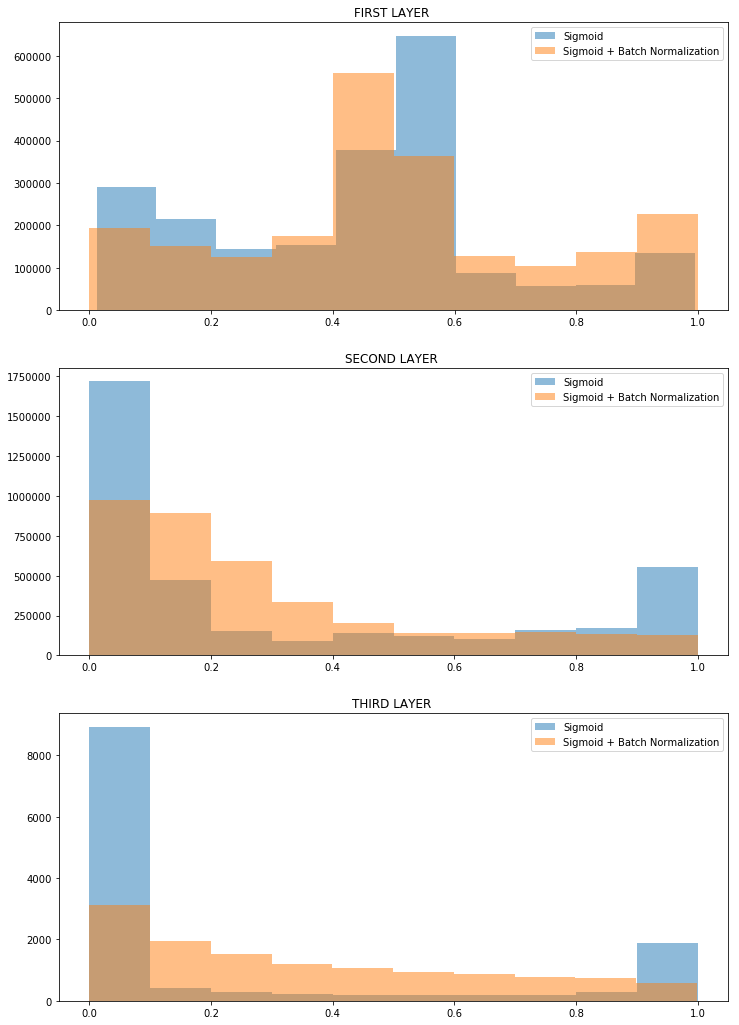

In [113]:
#Plot histograms of activation values for the 3 hidden layers of both models
#Taken values of all filters/channels related to the first 100 train samples 

fig, axs = plt.subplots(3, 1, figsize=(12,18));
_ = axs[0].hist(np.ravel(get_activations(model, CNN_x_test_fashion[0:100])['conv2d_5/Sigmoid:0']), alpha=0.5, label='Sigmoid')
_ = axs[0].hist(np.ravel(get_activations(cnn_batch, CNN_x_test_fashion[0:100])['activation_1/Sigmoid:0']), alpha=0.5, label='Sigmoid + Batch Normalization')
axs[0].legend()
_ = axs[0].set_title('FIRST LAYER ')

_ = axs[1].hist(np.ravel(get_activations(model, CNN_x_test_fashion[0:100])['conv2d_6/Sigmoid:0']), alpha=0.5, label='Sigmoid')
_ = axs[1].hist(np.ravel(get_activations(cnn_batch, CNN_x_test_fashion[0:100])['activation_2/Sigmoid:0']), alpha=0.5, label='Sigmoid + Batch Normalization')
axs[1].legend()
_ = axs[1].set_title('SECOND LAYER ')

_ = axs[2].hist(np.ravel(get_activations(model, CNN_x_test_fashion[0:100])['dense_6/Sigmoid:0']), alpha=0.5, label='Sigmoid')
_ = axs[2].hist(np.ravel(get_activations(cnn_batch, CNN_x_test_fashion[0:100])['activation_3/Sigmoid:0']), alpha=0.5, label='Sigmoid + Batch Normalization')
axs[2].legend()
_ = axs[2].set_title('THIRD LAYER ')

We can observe that, a part from the first layer that receive input data in both models, the second and third hidden layers are quite different: on the one hand, in the simple model (without batch normalization), we can see that many activation values are cloes to zero/one, that means many input values are very high (in absolute values), leading activation values on the saturating zone. This implies that for the first model many values of the gradient were actually very small (as expected), leading to poor performance during learning phase. On the other hand instead, the values on the activations of the model with batch normalization layers seem more uniformly distributed between 0 and 1 even in the second and third layers. 